In [1]:
import jax
import os

In [2]:
from moscot.problems.cross_modality import TranslationProblem
import numpy as np
import sys
import jax.numpy as jnp
import scanpy as sc
import matplotlib.pyplot as plt
from typing import Any, Tuple
from sklearn.linear_model import LinearRegression
import scipy
import os
from ott.geometry import costs, geometry, graph, pointcloud
import jax
import pandas as pd
import sklearn.preprocessing as pp

def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

def lr_predictor(source_train: jnp.ndarray, source_test: jnp.ndarray, target_features_predicted: jnp.ndarray, positive_weights: bool = False) -> jnp.ndarray:
    X_train=np.transpose(source_train)
    y_train=np.transpose(source_test)

    lr = LinearRegression(fit_intercept=False, positive=positive_weights)
    sol = lr.fit(X_train, y_train)
    return np.apply_along_axis(lambda x: np.average(target_features_predicted, axis=0, weights=x), axis=1, arr=sol.coef_)


In [3]:
adata_atac = sc.read("../../data/bone_marrow_atac.h5ad")
adata_rna = sc.read("../../data/bone_marrow_rna.h5ad")

In [4]:
def create_helper_col(x):
    if x["cell_type"] in ["Normoblast", "Erythroblast", "Proerythroblast"]:
        return x["cell_type"]
    return "other"
    
adata_atac.obs["helper"] = adata_atac.obs.apply(create_helper_col, axis=1)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/moscot_up/li

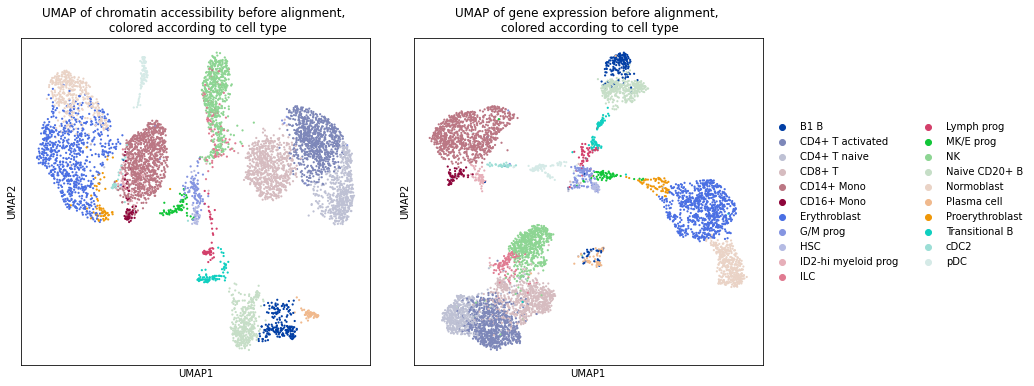

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [6]:
adata_atac.obsm["ATAC_lsi_l2_norm"] = pp.normalize(
    adata_atac.obsm["ATAC_lsi_red"], norm="l2"
)

In [7]:
adata_rna_red = adata_rna[~adata_rna.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()
adata_atac_red = adata_atac[~adata_atac.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()
adata_atac_complement = adata_atac[adata_atac.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()
adata_rna_complement = adata_rna[adata_rna.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

In [8]:
n_cells=len(adata_atac_red)

n_samples_train = int(n_cells * 0.6)
n_samples_test = n_cells - n_samples_train

inds_train = np.asarray(jax.random.choice(jax.random.PRNGKey(0), n_cells, (n_samples_train,), replace=False))
inds_test = list(set(list(range(n_samples_train))) - set(inds_train))



m_cells=len(adata_atac_complement)

m_samples_train_complement = int(m_cells * 0.6)
m_samples_test_complement = m_cells - m_samples_train_complement

inds_train_complement = np.asarray(jax.random.choice(jax.random.PRNGKey(0), m_cells, (m_samples_train_complement,), replace=False))
inds_test_complement = list(set(list(range(m_samples_train_complement))) - set(inds_train_complement))


adata_source_train = adata_atac_red[inds_train,:]
adata_source_test = adata_atac_red[inds_test,:]

adata_target_train = adata_rna_red[inds_train,:]
adata_target_test = adata_rna_red[inds_test,:]

adata_source_train_complement = adata_atac_complement[inds_train_complement,:]
adata_source_test_complement = adata_atac_complement[inds_test_complement,:]

adata_source_train_final = sc.concat(
    [adata_source_train, adata_source_train_complement],
    join="outer",
)

adata_source_test_final = sc.concat(
    [adata_source_test, adata_source_test_complement],
    join="outer",
)

target_train = np.concatenate((adata_target_train.obsm["geneactivity_scvi"], adata_target_train.obsm["GEX_X_pca"]), axis=1)
source_train = np.concatenate((adata_source_train_final.obsm["geneactivity_scvi"], adata_source_train_final.obsm["ATAC_lsi_l2_norm"]), axis=1)
source_test_red = np.concatenate((adata_source_test.obsm["geneactivity_scvi"], adata_source_test.obsm["ATAC_lsi_l2_norm"]), axis=1)
source_test = np.concatenate((adata_source_test_final.obsm["geneactivity_scvi"], adata_source_test_final.obsm["ATAC_lsi_l2_norm"]), axis=1)
target_test = np.concatenate((adata_target_test.obsm["geneactivity_scvi"], adata_target_test.obsm["GEX_X_pca"]), axis=1)
source_train_red = np.concatenate((adata_source_train.obsm["geneactivity_scvi"], adata_source_train.obsm["ATAC_lsi_l2_norm"]), axis=1)

2023-09-15 08:13:52.879773: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.140). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/home/icb/do

In [9]:
ftp = TranslationProblem(adata_src=adata_source_train_final, adata_tgt=adata_target_train)
ftp = ftp.prepare(
    src_attr="ATAC_lsi_l2_norm", tgt_attr="GEX_X_pca", joint_attr="geneactivity_scvi"
)
ftp = ftp.solve(epsilon=0.5e-2, alpha=0.7, tau_a=0.80, tau_b=1.0, max_iterations=10_000)

target_features_predicted = ftp["src", "tgt"].pull(target_train, scale_by_marginals=True, normalize=False)

                                                                  

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3734, 2985)].                                          


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [10]:
target_pred = lr_predictor(source_train, source_test_red, target_features_predicted)
foscttm(target_pred, target_test)

0.2584

In [11]:
adata_source_test_final.obs["left_reweighting"] = lr_predictor(source_train, source_test, ftp["src", "tgt"].solution.a*len(ftp["src", "tgt"].solution.a), positive_weights=True)

In [12]:
adata_source_train_final.obs["left_reweighting"] = ftp["src", "tgt"].solution.a*len(ftp["src", "tgt"].solution.a)

In [13]:
df_test_result = adata_source_test_final.obs[["helper", "left_reweighting"]]
df_train_result = adata_source_train_final.obs[["helper", "left_reweighting"]]

In [14]:
df1 = df_test_result.groupby("helper").agg(["mean", "var"])
df1

/tmp/ipykernel_2804160/1755506489.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1 = df_test_result.groupby("helper").agg(["mean", "var"])


left_reweighting          
                            mean       var
helper                                    
Erythroblast            0.819674  0.021370
Normoblast              0.788398  0.020817
Proerythroblast         0.841931  0.025272
other                   0.944930  0.038146

In [15]:
df2 = df_train_result.groupby("helper").agg(["mean", "var"])
df2

/tmp/ipykernel_2804160/2632600355.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = df_train_result.groupby("helper").agg(["mean", "var"])


left_reweighting          
                            mean       var
helper                                    
Erythroblast            0.167642  0.031601
Normoblast              0.160258  0.037383
Proerythroblast         0.411629  0.100667
other                   1.206313  2.320681

In [16]:
df_train_result["cell_type"] = adata_source_train_final.obs["cell_type"]
df_test_result["cell_type"] = adata_source_test_final.obs["cell_type"]

/tmp/ipykernel_2804160/486172551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_result["cell_type"] = adata_source_train_final.obs["cell_type"]
/tmp/ipykernel_2804160/486172551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_result["cell_type"] = adata_source_test_final.obs["cell_type"]


In [17]:
df_test_result.to_csv("discrete_ufgw_80_test.csv")
df_train_result.to_csv("discrete_ufgw_80_train.csv")